In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import csv
import time
import tensorflow as tf
import keras
import glob
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Flatten, Dense, Dropout, UpSampling2D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import ImageGrid
from pprint import pprint
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import EarlyStopping
import logging
logging.getLogger('tensorflow').disabled = True
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Image Augmentation Functions

In [2]:
from scipy.ndimage import binary_erosion
import random
import math

def flip_horizontal(img):
    background = tf.constant([-1.0, -1.0, -1.0])
    mask = tf.math.greater(img, background)
    # print("mask.shape", tf.shape(mask), mask.shape)
    tmp = tf.math.logical_or(mask[:,:,0], mask[:,:,1])
    mask = tf.math.logical_or(mask[:,:,2], tmp)
    # print("mask.shape", tf.shape(mask), mask.shape)
    #print("mask.dtype", mask.dtype)
    #mask = tf.cast(mask, tf.bool)
    mshape = tf.shape(mask)
    mask = tf.reshape(mask, [mshape[0], mshape[1], 1]) #mshape[2], 1])
    mshape = tf.shape(mask)
    flipped = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    mask = tf.where(mask, tf.ones(mshape), tf.zeros(mshape))
    kernel = tf.zeros([3, 3, mshape[2]])#mshape[3]]) 
    mask = tf.reshape(mask, [1, mshape[0], mshape[1], 1])
    mask = tf.nn.erosion2d(mask, kernel, (1,1,1,1), "SAME", "NHWC", (1,1,1,1))
        
    mask = tf.math.greater(mask, 0.0)
    mask = tf.reshape(mask, [mshape[0], mshape[1], 1])
    
    # Assuming blue is out of screen, green is to the (viewer's) right, and red is down?
    # So left-right flip means negating the green channel
    mat = [[1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,1.0]]
    mult = tf.linalg.matvec(mat, flipped)
    fshape = tf.shape(flipped)
    # print("flipped.shape", flipped.shape)
    flipped = tf.where(mask, mult, tf.ones(fshape)*-1.0)
    return flipped


def myrotate(img):
    return tf.keras.preprocessing.image.apply_affine_transform(img, theta=angle, zx=zoom, zy=zoom)


def random_rotate(img):
    #res = []
    res = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    ishape = tf.shape(img)
    for i in range(ishape[0]):
        global angle, zoom
        angle = (random.random()-0.5)*40 # plus or minus 20 degree in degrees (0.1745 radians)
        zoom = 1.0 + (random.random()-0.5)*0.2
        # print("angle", angle)
        background = tf.constant([-1.0, -1.0, -1.0])
        mask = tf.math.greater(img[i, :,:,:], background)
        tmp = tf.math.logical_or(mask[:,:,0], mask[:,:,1])
        mask = tf.math.logical_or(mask[:,:,2], tmp)
        mshape = tf.shape(mask)
        mask = tf.reshape(mask, [mshape[0], mshape[1], -1])
        img_i = img[i, :,:,:]
        # print("img_i.shape", tf.shape(img_i))
        img_i = tf.transpose(img_i, [2, 0, 1])
        #flipped = tf.keras.preprocessing.image.apply_affine_transform(img_i, theta=angle, zx=zoom, zy=zoom) #, row_axis=0, col_axis=1, channel_axis=2)
        #flipped = tf.py_function(func=tf.keras.preprocessing.image.apply_affine_transform, inp=(img_i, theta=angle, zx=zoom, zy=zoom), Tout=tf.float32) #, row_axis=0, col_axis=1, channel_axis=2)
        flipped = tf.py_function(func=myrotate, inp=[img_i], Tout=tf.float32) #, row_axis=0, col_axis=1, channel_axis=2)
        flipped = tf.transpose(flipped, [1, 2, 0])
        mask = tf.transpose(mask, [2,0,1])
        mshape = tf.shape(mask)
        mask = tf.where(mask, tf.ones(mshape), tf.zeros(mshape))
        #mask = tf.keras.preprocessing.image.apply_affine_transform(mask, theta=angle, zx=zoom, zy=zoom)
        mask = tf.py_function(func=myrotate, inp=[mask], Tout=tf.float32)
        mask = tf.math.greater(mask, 0.0)
        mask = tf.transpose(mask, [1,2,0])
        #mask = tf.where(mask, tf.ones(mask.shape), tf.zeros(mask.shape))
        #kernel = tf.zeros([3, 3, mask.shape[2]]) 
        #mask = tf.reshape(mask, [1, mask.shape[0], mask.shape[1], mask.shape[2]])
        #mask = tf.nn.erosion2d(mask, kernel, (1,1,1,1), "SAME", "NHWC", (1,1,1,1))
        
        #mask = tf.math.greater(mask, 0.0)
        #mask = tf.reshape(mask, [mask.shape[1], mask.shape[2], mask.shape[3]])
        
        # Assuming blue is out of screen, green is to the (viewer's) right, and red is down?
        # So left-right flip means negating the green channel
        angle = math.pi*angle/180.0
        mat = [[1.0,0.0,0.0],[0.0,math.cos(angle),math.sin(angle)],[0.0,-math.sin(angle),math.cos(angle)]]
        #print("flipped.shape", flipped.shape)
        mult = tf.linalg.matvec(mat, flipped)
        fshape = tf.shape(flipped)
    
        flipped = tf.where(mask, mult, tf.ones(fshape)*-1.0)
        #res.append(flipped)
        res = res.write(res.size(), flipped)
    flipped = res.stack()#tf.stack(res)
    # print("flipped.shape", tf.shape(flipped))
    return flipped

def random_rotate_single(img):
    global angle, zoom
    angle = (random.random()-0.5)*40 # plus or minus 20 degree in degrees (0.1745 radians)
    zoom = 1.0 + (random.random()-0.5)*0.2
    # # print("angle", angle)
    background = tf.constant([-1.0, -1.0, -1.0])
    mask = tf.math.greater(img, background)
    tmp = tf.math.logical_or(mask[:,:,0], mask[:,:,1])
    mask = tf.math.logical_or(mask[:,:,2], tmp)
    mshape = tf.shape(mask)
    mask = tf.reshape(mask, [mshape[0], mshape[1], -1])
    # print("img.shape", tf.shape(img))
    img = tf.transpose(img, [2, 0, 1])
    #flipped = tf.keras.preprocessing.image.apply_affine_transform(img_i, theta=angle, zx=zoom, zy=zoom) #, row_axis=0, col_axis=1, channel_axis=2)
    #flipped = tf.py_function(func=tf.keras.preprocessing.image.apply_affine_transform, inp=(img_i, theta=angle, zx=zoom, zy=zoom), Tout=tf.float32) #, row_axis=0, col_axis=1, channel_axis=2)
    flipped = tf.py_function(func=myrotate, inp=[img], Tout=tf.float32) #, row_axis=0, col_axis=1, channel_axis=2)
    flipped = tf.transpose(flipped, [1, 2, 0])
    mask = tf.transpose(mask, [2,0,1])
    mshape = tf.shape(mask)
    mask = tf.where(mask, tf.ones(mshape), tf.zeros(mshape))
    #mask = tf.keras.preprocessing.image.apply_affine_transform(mask, theta=angle, zx=zoom, zy=zoom)
    mask = tf.py_function(func=myrotate, inp=[mask], Tout=tf.float32)
    mask = tf.math.greater(mask, 0.0)
    mask = tf.transpose(mask, [1,2,0])
    #mask = tf.where(mask, tf.ones(mask.shape), tf.zeros(mask.shape))
    #kernel = tf.zeros([3, 3, mask.shape[2]]) 
    #mask = tf.reshape(mask, [1, mask.shape[0], mask.shape[1], mask.shape[2]])
    #mask = tf.nn.erosion2d(mask, kernel, (1,1,1,1), "SAME", "NHWC", (1,1,1,1))
        
    #mask = tf.math.greater(mask, 0.0)
    #mask = tf.reshape(mask, [mask.shape[1], mask.shape[2], mask.shape[3]])
        
    # Assuming blue is out of screen, green is to the (viewer's) right, and red is down?
    # So left-right flip means negating the green channel
    angle = math.pi*angle/180.0
    mat = [[1.0,0.0,0.0],[0.0,math.cos(angle),math.sin(angle)],[0.0,-math.sin(angle),math.cos(angle)]]
    #print("flipped.shape", flipped.shape)
    mult = tf.linalg.matvec(mat, flipped)
    fshape = tf.shape(flipped)
    
    flipped = tf.where(mask, mult, tf.ones(fshape)*-1.0)
        
    return flipped
#flipped_dataset = train_dataset.map(flip_horizontal)

def applyFlip(ds):
  return train_dataset.map(flip_horizontal)

def applyRotate(ds):
  return train_dataset.map(random_rotate_single)

def flipRotate(img):
  img = flip_horizontal(img)
  img = random_rotate_single(img)
  return img
  
def applyFlipRotate(ds):
  return train_dataset.map(flipRotate)
  
# for images in train_dataset.take(1):
#     flip = flip_horizontal(images)
#     print("images.shape", images.shape)
    
#     flip = random_rotate(flip)
#     print("flip.shape", flip.shape)
#     for ax, img in zip(ImageGrid(plt.figure(figsize=(12, 8)), 111, nrows_ncols=(2, 3), axes_pad=0.3), flip):
#         ax.imshow((img+1)/2)
#         ax.axis('off')
#     for ax, img in zip(ImageGrid(plt.figure(figsize=(12, 8)), 111, nrows_ncols=(2, 3), axes_pad=0.3), images):
#         ax.imshow((img+1)/2)
#         ax.axis('off')

# plt.suptitle('Examples Of Six Training Images from flipped dataset', fontsize='xx-large',fontweight='heavy')
# plt.show()

# Preparation and presentation of datasets

### Acquire and Preprocess Dataset

In [3]:
BATCH_SIZE = 15

img_dir = '../dataset/sfs-net/'

train_files = glob.glob(img_dir + 'train/0003/*normal*.png')
test_files = glob.glob(img_dir + 'test/0603/*normal*.png')

def preprocess(images):
    images = tf.image.resize(images, [256, 256])
    images = tf.cast(images, tf.float32)
    images = (images - 127.5) / 127.5 # [-1, 1]
    return images


def load_and_preprocess_image(file_path):
    # print("file_path", file_path)
    # Load the image from file
    image = tf.io.read_file(file_path)
    # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Preprocess the image
    image = preprocess(image)
    return image


def normalise(images):
    images,images_norm = tf.linalg.normalize(images, axis=2) #Normalise the input data
    return images


train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

print("Original training dataset size:", len(train_files))
print("Original testing dataset size:", len(test_files))

train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)
img = train_dataset.take(1)
print("Original - img.element_spec", img.element_spec)
train_dataset_width = int(img.element_spec.shape[0])
train_dataset_height = int(img.element_spec.shape[1])

# augmentations
flipped_dataset = train_dataset.map(flip_horizontal)#apply(applyFlip)#
rotated_dataset = train_dataset.map(random_rotate_single)#apply(applyRotate)#
flipped_rotated = train_dataset.map(flipRotate)#apply(applyFlipRotate)#apply(applyFlip).apply(applyRotate)

train_dataset = train_dataset.concatenate(rotated_dataset)
train_dataset = train_dataset.concatenate(flipped_dataset)
train_dataset = train_dataset.concatenate(flipped_rotated)

#train_dataset.save(img_dir + 'train/augmented/')
#train_dataset = tf.data.Dataset.load(img_dir + 'train/augmented/')

train_dataset = train_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

print("Augmented training dataset size:", len(list(train_dataset)))
print("Augmented testing dataset size:", len(list(test_dataset)))

train_dataset = train_dataset.shuffle(len(train_files)*2).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print("Total number of batches in training dataset:", len(list(train_dataset)))
print("Total number of batches in testing dataset:", len(list(test_dataset)))
print("train dataset: ", tf.data.DatasetSpec.from_value(train_dataset))
print("test dataset: ", tf.data.DatasetSpec.from_value(test_dataset))

train_dataset = train_dataset.prefetch(100).cache()

Original training dataset size: 0
Original testing dataset size: 0


TypeError: in user code:

    File "C:\Users\60528\AppData\Local\Temp\ipykernel_27184\1298874945.py", line 18, in load_and_preprocess_image  *
        image = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


### Show some images on the train dataset

In [ ]:
for images in train_dataset.take(1):
    for ax, img in zip(ImageGrid(plt.figure(figsize=(9, 6)), 111, nrows_ncols=(2, 3)), images):
        ax.imshow((img+1)/2)
        ax.axis('off')
plt.suptitle('Examples Of Training Images on train dataset', fontsize='xx-large',fontweight='heavy')
plt.tight_layout()
plt.show()

### Show some images on the test dataset

In [ ]:
for images in test_dataset.take(1):
    for ax, img in zip(ImageGrid(plt.figure(figsize=(9, 6)), 111, nrows_ncols=(2, 3)), images):
        ax.imshow((img+1)/2)
        ax.axis('off')
plt.suptitle('Examples Of Testing Images on test dataset', fontsize='xx-large',fontweight='heavy')
plt.tight_layout()
plt.show()

# Mask Code Set

### Generate Irregular Mask (batch size)

In [ ]:
def mask_irregular(batch_size, mask_width, mask_height):
    
    size = int(round((mask_width + mask_height) * 0.03))
    mask = np.zeros((batch_size,mask_width,mask_height,1))
    
    for _ in range(np.random.randint(1, 20)):
        
        x1, x2 = np.random.randint(1, mask_width, batch_size), np.random.randint(1, mask_width, batch_size)
        y1, y2 = np.random.randint(1, mask_height, batch_size), np.random.randint(1, mask_height, batch_size)
        thickness = np.random.randint(1, size, batch_size)
        
        for i in range(batch_size):
            cv2.line(mask[i],(x1[i], y1[i]),(x2[i],y2[i]),(1,1,1), thickness[i])

    return np.float32(((1 - mask)*2) - 1) # [-1, 1]

In [ ]:
irregular_mask_examples = mask_irregular(6, train_dataset_width, train_dataset_height)

for ax, img in zip(ImageGrid(plt.figure(figsize=(9, 6)), 111, nrows_ncols=(2, 3)), 
                   irregular_mask_examples):
    ax.imshow((img+1)/2, cmap='binary')
    ax.axis('off')
plt.suptitle('Examples of the Irregular Mask Channels', fontsize='xx-large',fontweight='heavy')
plt.tight_layout()
plt.show()

### Generate the masked imgs (batch size)

In [ ]:
def masked_imgs(raw_imgs, mask_channels):
    
    raw_imgs = (raw_imgs + 1.0) / 2.0 # [0, 1]
    mask_channels = (mask_channels + 1.0) / 2.0 # [0, 1]
    
    # masked_images = np.multiply(raw_imgs, mask_channels)
    masked_images = tf.multiply(raw_imgs, mask_channels)  # 使用 tf.multiply 替代 np.multiply
    
    masked_images = (masked_images * 2.0) - 1.0 # [-1, 1]
    
#     masked_images[:][masked_images[:] == 0] = 1. # Set the white mask
    
    return masked_images

In [ ]:
for images_batch in test_dataset.take(1):
    raw_images_examples = images_batch[:2]

irregular_mask_examples = irregular_mask_examples[:2]
masked_images_examples = masked_imgs(raw_images_examples, irregular_mask_examples)

grid = ImageGrid(plt.figure(figsize=(9, 6)), 111, nrows_ncols=(2, 3))

for i in range(2):
    ax = grid[i*3]
    ax.imshow((raw_images_examples[i]+1)/2)
    ax.axis('off')
    if i == 0:
        ax.set_title('Raw Img')
    
    ax = grid[i*3+1]
    ax.imshow((irregular_mask_examples[i]+1)/2, cmap='binary')
    ax.axis('off')
    if i == 0:
        ax.set_title('Mask Channel')
    
    ax = grid[i*3+2]
    ax.imshow((masked_images_examples[i]+1)/2)
    ax.axis('off')
    if i == 0:
        ax.set_title('Masked Img')
    
plt.suptitle('Examples of the Masked Images', fontsize='xx-large',fontweight='heavy')
plt.tight_layout()
plt.show()

### Generate the pred only masked region imgs (batch size)

In [ ]:
def only_masked_region_pred_imgs(mask_channels, masked_imgs, pred_imgs):
    
    mask_channels = (mask_channels + 1.0) / 2.0 # [0, 1]
    masked_imgs = (masked_imgs + 1.0) / 2.0 # [0, 1]
    pred_imgs = (pred_imgs + 1.0) / 2.0 # [0, 1]
    
    masked_region_pred_imgs = masked_imgs + pred_imgs * (1.0 - mask_channels)
    
    masked_region_pred_imgs = (masked_region_pred_imgs * 2.0) - 1.0 # [-1, 1]
    
    return masked_region_pred_imgs

# Painting Function

In [ ]:
def generator_plot_images(gen_model, text, dataset, num=3, save_path='./saved_images', epoch=0, save_images=False):
    os.makedirs(save_path, exist_ok=True)
    
    for images_batch in dataset.take(1):
        raw_images = images_batch
        mask_channels = mask_irregular(raw_images.shape[0], raw_images.shape[1], raw_images.shape[2])
        masked_images = masked_imgs(raw_images, mask_channels)
        pred_images = gen_model([masked_images, mask_channels], training=False)
        pred_images, pred_norm = tf.linalg.normalize(pred_images, axis=3)

        masked_region_pred_images = only_masked_region_pred_imgs(mask_channels, masked_images, pred_images)
    
    grid = ImageGrid(plt.figure(figsize=(12, num*3)), 111, nrows_ncols=(num, 4))
    
    for i in range(num):
        
        ax = grid[i*4]
        ax.imshow((raw_images[i]+1)/2)
        ax.axis('off')
        if i == 0:
            ax.set_title('Raw {} Img'.format(text))

        ax = grid[i*4+1]
        ax.imshow((masked_images[i]+1)/2)
        ax.axis('off')
        if i == 0:
            ax.set_title('Masked {} Img'.format(text))
            
        ax = grid[i*4+2]
        ax.imshow((pred_images[i]+1)/2)
        ax.axis('off')
        if i == 0:
            ax.set_title('Pred {} Img'.format(text))
        
        ax = grid[i*4+3]
        ax.imshow((masked_region_pred_images[i]+1)/2)
        ax.axis('off')
        if i == 0:
            ax.set_title('Pred Only Masked Reg. {} Img'.format(text))
        
    plt.tight_layout()
    if save_images:
        image_save_path = os.path.join(save_path, f'{text}_epoch_{epoch}.png')
        plt.savefig(image_save_path)   
    plt.show()

In [4]:
def plot_loss_metric(train_loss, train_metric, test_loss, test_metric, title, metric, start=0):
    x_values = range(start, start + len(train_loss))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting the training set
    ax_train_loss = ax1
    ax_train_metric = ax1.twinx()
    ax_train_loss.plot(x_values, train_loss, color='tab:red')
    ax_train_metric.plot(x_values, train_metric, color='tab:blue')

    ax_train_loss.set_xlabel('Epochs')
    ax_train_loss.set_ylabel('Loss', color='tab:red')
    ax_train_metric.set_ylabel(metric, color='tab:blue')

    ax_train_loss.tick_params(axis='y', labelcolor='tab:red')
    ax_train_metric.tick_params(axis='y', labelcolor='tab:blue')

    ax1.set_title('Train - ' + title)

    # Plotting the test set
    ax_test_loss = ax2
    ax_test_metric = ax2.twinx()
    ax_test_loss.plot(x_values, test_loss, color='tab:green')
    ax_test_metric.plot(x_values, test_metric, color='tab:purple')

    ax_test_loss.set_xlabel('Epochs')
    ax_test_loss.set_ylabel('Loss', color='tab:green')
    ax_test_metric.set_ylabel(metric, color='tab:purple')

    ax_test_loss.tick_params(axis='y', labelcolor='tab:green')
    ax_test_metric.tick_params(axis='y', labelcolor='tab:purple')

    ax2.set_title('Test - ' + title)

    plt.tight_layout()
    plt.show()

# Model Definition Code Set

### Define the loss

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
# Cosine Similarity
cosine_loss = tf.keras.losses.CosineSimilarity(axis=3)

### Generator (encoder-decoder network)

In [6]:
class UnitNormalize(tf.keras.layers.Layer):
    def __init__(self):
        super(UnitNormalize, self).__init__()

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=2, epsilon=1e-6)

In [7]:
def generator_model():
    
    masked_image = tf.keras.layers.Input(shape=((256, 256, 3)))
    mask = tf.keras.layers.Input(shape=((256, 256, 1)))
    maskedImage_mask = tf.keras.layers.concatenate([masked_image, mask])
    
    # Encoder with skip connections
    skips = []
    
    # Encoder - Input a masked image and mask
    
    # (256, 256, 4) -> (128, 128, 64) 
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(maskedImage_mask)
    x = LeakyReLU(alpha=0.2)(x)
    skips.append(x)
    
    # (128, 128, 64) -> (64, 64, 128) 
    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)
    
    # (64, 64, 128) -> (32, 32, 256) 
    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)
    
    # (32, 32, 256) -> (16, 16, 512) 
    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)
    
    # (16, 16, 512) -> (8, 8, 512) 
    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)
    
    # (8, 8, 512) -> (4, 4, 512) 
    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)
    
    # (4, 4, 512) -> (2, 2, 512) 
    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)

    # (2, 2, 512) -> (1, 1, 512) 
    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    skips.append(x)
    
    # Decoder
    # Decoder with skip connections
    # Assuming x is the output of the last layer of the encoder
    for skip_layer in reversed(skips[:-1]):  # Not using the last skip connection
        x = Conv2DTranspose(x.shape[-1] // 2, kernel_size=4, strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)
        x = Concatenate()([x, skip_layer])  # skip connection
    
    # Final layer
    # (128, 128, 16) -> (256, 256, 3)
    x = Conv2DTranspose(3, kernel_size=4,strides=2,padding="same")(x)
    
    x = Activation('tanh')(x) # [-1, 1]
    output = UnitNormalize()(x)
    
    model = tf.keras.Model(inputs=[masked_image, mask], outputs=output)

    return model

In [8]:
def generator_loss(target_images, generated_images): 
                   # lambda_reconstruction = 10, lambda_adversarial=1):
    
    reconstruction_loss = 1 + cosine_loss(target_images, generated_images)
    
#     adversarial_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
#     total_loss = lambda_reconstruction * reconstruction_loss + lambda_adversarial * adversarial_loss
    
    return reconstruction_loss

In [9]:
def generator_ssim(target_images, generated_images):
    ssim = tf.image.ssim(target_images, generated_images, max_val=2.0)
    ssim = tf.reduce_mean(ssim)
    return ssim

In [10]:
def generator_psnr(target_images, generated_images):
    psnr = tf.image.psnr(target_images, generated_images, max_val=2.0)
    psnr = tf.reduce_mean(psnr)
    return psnr

In [11]:
generator = generator_model()
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [13]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 4)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

### Discriminator

In [15]:
def discriminator_model():
    
    image = tf.keras.layers.Input(shape=(256, 256, 3), name="input_layer")
    
    # (256, 256, 3) -> (128, 128, 32)
    x = Conv2D(32, kernel_size=4, strides=2, padding="same", name="conv1")(image)
    x = LeakyReLU(alpha=0.2)(x)
    
    # (128, 128, 32) -> (64, 64, 64)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", name="conv2")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # (64, 64, 64) -> (32, 32, 128)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", name="conv3")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # (32, 32, 128) -> (16, 16, 256)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", name="conv4")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # (16, 16, 256) -> (8, 8, 512)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", name="conv5")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # (8, 8, 512) -> (4, 4, 1024)
    x = Conv2D(1024, kernel_size=4, strides=2, padding="same", name="conv6")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # (4, 4, 1024) -> (1, 1, 1)
    x = Conv2D(1, kernel_size=4, strides=1, padding="valid", name="conv7")(x)

    x = Flatten()(x)
    
    output = Dense(1, name="dense1")(x)
    output = Activation('sigmoid')(output)
    
    model = tf.keras.Model(inputs=image, outputs=output)
    
    return model

In [16]:
# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

In [17]:
# def discirminator_acc(real_output, fake_output):
#     real_acc = tf.reduce_mean(tf.cast(tf.greater(real_output, 0.5), tf.float32))
#     fake_acc = tf.reduce_mean(tf.cast(tf.less(fake_output, 0.5), tf.float32))
#     total_acc = (real_acc + fake_acc) / 2.0
#     return total_acc

In [18]:
discriminator = discriminator_model()
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [19]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      1568      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 64, 64, 64)        32832     
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                           

# Demonstration of an untrained model

### Use of (untrained) discriminator to classify the generated images as true or false

In [24]:
# real_decision = discriminator(raw_images_examples)
pred_images_examples = generator([masked_images_examples, irregular_mask_examples], training=False)
# fake_decision = discriminator(pred_images_examples)

# print ("Real Images: ",real_decision)
# print ("Fake Images: ",fake_decision)
# print("Discirminator Loss: ", discriminator_loss(real_decision,fake_decision))
# print("Discirminator Accuracy: ", discirminator_acc(real_decision,fake_decision))

### Generate some images using (untrained) generator

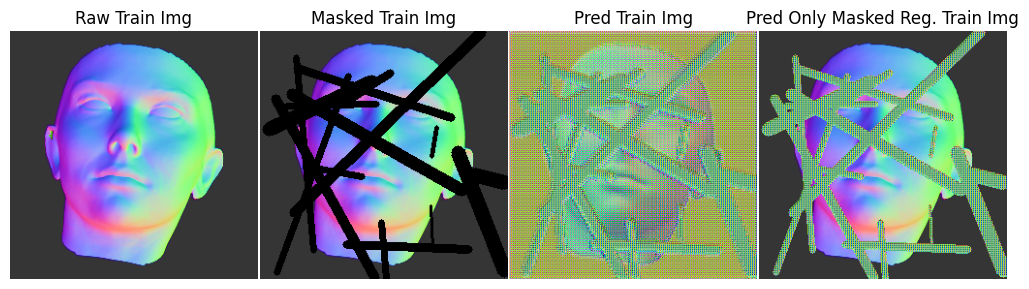

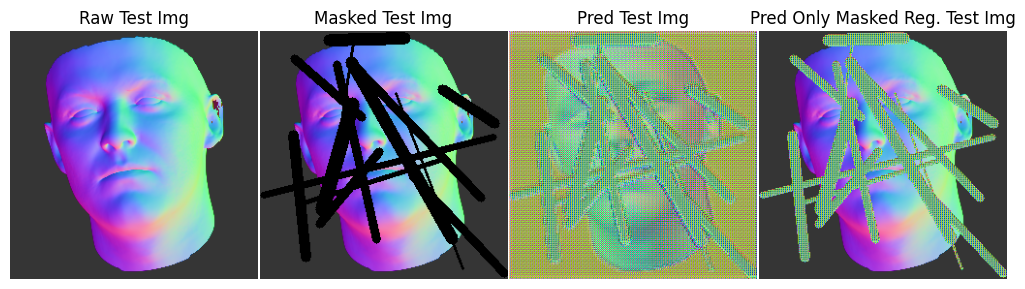

In [25]:
generator_plot_images(generator, 'Train', train_dataset, num = 1)
generator_plot_images(generator, 'Test', test_dataset, num = 1)

In [26]:
print("Generator Loss: ", generator_loss(raw_images_examples,pred_images_examples))
print("Generator SSIM: ", generator_ssim(raw_images_examples,pred_images_examples))
print("Generator PSNR: ", generator_psnr(raw_images_examples,pred_images_examples))

Generator Loss:  tf.Tensor(1.0763681, shape=(), dtype=float32)
Generator SSIM:  tf.Tensor(-0.010043526, shape=(), dtype=float32)
Generator PSNR:  tf.Tensor(10.649197, shape=(), dtype=float32)


# Training Code Set

### Define Generator and Discriminator training steps for a batch

In [27]:
@tf.function
def train_generator_step(train_raw_images, train_mask_channels, train_masked_images):
    with tf.GradientTape() as gen_tape:
        train_generated_images = generator([train_masked_images, train_mask_channels], training=True)
        # train_fake_output = discriminator(train_generated_images, training=False)
        gen_loss = generator_loss(train_raw_images, train_generated_images)
        gen_ssim = generator_ssim(train_raw_images, train_generated_images)
        gen_psnr = generator_psnr(train_raw_images, train_generated_images)
        
    gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    return gradients, gen_loss, gen_ssim, gen_psnr

In [28]:
# @tf.function
# def train_discriminator_step(train_raw_images, train_mask_channels, train_masked_images):
#     with tf.GradientTape() as disc_tape:
#         train_generated_images = generator([train_masked_images, train_mask_channels], training=False)
#         train_real_output = discriminator(train_raw_images, training=True)
#         train_fake_output = discriminator(train_generated_images, training=True)
        
#         disc_loss = discriminator_loss(train_real_output, train_fake_output)
#         disc_acc = discirminator_acc(train_real_output, train_fake_output)

#     gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#     # discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    
#     return gradients, disc_loss, disc_acc

### Define a function to train a list of batches

In [29]:
def train_batches(batches_list):
    gen_loss_total = 0
    gen_ssim_total = 0
    gen_psnr_total = 0
    # disc_loss_total = 0
    # disc_acc_total = 0

    # cumulative gradient
    accumulated_gen_gradients = [tf.zeros_like(var) for var in generator.trainable_variables]
    # accumulated_disc_gradients = [tf.zeros_like(var) for var in discriminator.trainable_variables]
    
    for batch in batches_list:
        train_raw_images = batch
        train_mask_channels = mask_irregular(train_raw_images.shape[0], train_raw_images.shape[1], train_raw_images.shape[2])
        train_masked_images = masked_imgs(train_raw_images, train_mask_channels)
        
        gen_gradients, gen_loss, gen_ssim, gen_psnr = train_generator_step(train_raw_images, train_mask_channels, train_masked_images)
        # disc_gradients, disc_loss, disc_acc = train_discriminator_step(train_raw_images, train_mask_channels, train_masked_images)

        # cumulative gradient
        for i in range(len(accumulated_gen_gradients)):
            accumulated_gen_gradients[i] += gen_gradients[i]
        # for i in range(len(accumulated_disc_gradients)):
        #     accumulated_disc_gradients[i] += disc_gradients[i]
        
        gen_loss_total += gen_loss.numpy()
        gen_ssim_total += gen_ssim.numpy()
        gen_psnr_total += gen_psnr.numpy()
        # disc_loss_total += disc_loss.numpy()
        # disc_acc_total += disc_acc.numpy()

    # Applying cumulative gradients
    generator_optimizer.apply_gradients(zip(accumulated_gen_gradients, generator.trainable_variables))
    # discriminator_optimizer.apply_gradients(zip(accumulated_disc_gradients, discriminator.trainable_variables))
    
    num_batches = len(batches_list)
    return (gen_loss_total / num_batches, gen_ssim_total / num_batches, gen_psnr_total / num_batches)
    
    # return (gen_loss_total / num_batches, gen_ssim_total / num_batches, gen_psnr_total / num_batches,
    #         disc_loss_total / num_batches, disc_acc_total / num_batches)

### Evaluate the function for the dataset

In [30]:
# Evaluating data from a single batch
@tf.function
def evaluate_batch(raw_images, mask_channels):
    masked_images = masked_imgs(raw_images, mask_channels)
    generated_images = generator([masked_images, mask_channels], training=False)
    # real_output = discriminator(raw_images, training=False)
    # fake_output = discriminator(generated_images, training=False)

    return {
        'gen_loss': generator_loss(raw_images, generated_images),
        'gen_ssim': generator_ssim(raw_images, generated_images),
        'gen_psnr': generator_psnr(raw_images, generated_images)
        # 'disc_loss': discriminator_loss(real_output, fake_output),
        # 'disc_acc': discirminator_acc(real_output, fake_output)
    }

# Overall assessment function
def assessment(dataset):
    metrics_sums = {
        'gen_loss': 0,
        'gen_ssim': 0,
        'gen_psnr': 0
        # 'disc_loss': 0,
        # 'disc_acc': 0
    }
    batch_count = 0
    
    for images_batch in dataset:
        batch_metrics = evaluate_batch(images_batch, mask_irregular(images_batch.shape[0], images_batch.shape[1], images_batch.shape[2]))
        batch_count += 1

        for key in metrics_sums:
            metrics_sums[key] += batch_metrics[key].numpy()

    return {key: total / batch_count for key, total in metrics_sums.items()}

### Processing batch data

In [31]:
def process_batches(dataset, batches_list_num):
    train_dataset_batches_list = []
    epoch_metrics = {
        "train_gen_loss": [], "train_gen_ssim": [], "train_gen_psnr": []
    }

    for i, images_batch in enumerate(dataset):
        train_dataset_batches_list.append(images_batch)
        if (i + 1) % batches_list_num == 0:
            batch_metrics = train_batches(train_dataset_batches_list)
            train_dataset_batches_list = []
            for key, value in zip(epoch_metrics.keys(), batch_metrics):
                    epoch_metrics[key].append(value)

    # Check for unprocessed batch
    if train_dataset_batches_list:
        batch_metrics = train_batches(train_dataset_batches_list)
        train_dataset_batches_list = []
        for key, value in zip(epoch_metrics.keys(), batch_metrics):
                epoch_metrics[key].append(value)

    return epoch_metrics

### Record training information to CSV file

In [32]:
def record_training_info(log_file, current_epoch, metrics_lists, elapsed_time):
    with open(log_file, "a", newline='') as file:
        writer = csv.writer(file)
        if os.stat(log_file).st_size == 0:
            writer.writerow(["Epoch"] + list(metrics_lists.keys()) + ["Elapsed Time (Seconds)"])

        writer.writerow([current_epoch] + [sum(metrics) / len(metrics) for metrics in metrics_lists.values()] + [elapsed_time])

### Print training information

In [33]:
def print_training_info(current_epoch, total_epochs, metrics_lists, elapsed_time):
    print(f"Epoch {current_epoch}/{total_epochs}  "
          f"Train[G_Loss:{metrics_lists['train_gen_loss'][-1]:.5f} SSIM:{metrics_lists['train_gen_ssim'][-1] * 100:.2f}% PSNR:{metrics_lists['train_gen_psnr'][-1]:.2f}]"
          f"Test[G_Loss:{metrics_lists['test_gen_loss'][-1]:.5f} SSIM:{metrics_lists['test_gen_ssim'][-1] * 100:.2f}% PSNR:{metrics_lists['test_gen_psnr'][-1]:.2f}]"
          f"- {elapsed_time:.0f}s")

### Charting metrics

In [34]:
def plot_metrics(metrics_lists):
    start_epoch = 1
    plot_loss_metric(metrics_lists['train_gen_loss'], metrics_lists['train_gen_ssim'], 
                     metrics_lists['test_gen_loss'], metrics_lists['test_gen_ssim'], 
                     'Generator Loss and SSIM', 'SSIM', start=start_epoch)
    plot_loss_metric(metrics_lists['train_gen_loss'], metrics_lists['train_gen_psnr'], 
                     metrics_lists['test_gen_loss'], metrics_lists['test_gen_psnr'], 
                     'Generator Loss and PSNR', 'PSNR', start=start_epoch)
    # plot_loss_metric(metrics_lists['train_disc_loss'], metrics_lists['train_disc_acc'], 
    #                  metrics_lists['test_disc_loss'], metrics_lists['test_disc_acc'], 
    #                  'Discriminator Loss and Accuracy', 'Accuracy', start=start_epoch)

In [35]:
def load_metrics_from_csv(log_file):
    metrics_lists = {
        'train_gen_loss': [], 'train_gen_ssim': [], 'train_gen_psnr': [],
        'test_gen_loss': [], 'test_gen_ssim': [], 'test_gen_psnr': []
    }

    if os.path.exists(log_file) and os.path.getsize(log_file) > 0:
        with open(log_file, "r") as file:
            reader = csv.DictReader(file)
            for row in reader:
                for key in metrics_lists.keys():
                    metrics_lists[key].append(float(row[key]))

    return metrics_lists

### Save checkpoints

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=1)

### Restore the latest saved checkpoint (if exist)

In [37]:
checkpoint.restore(checkpoint_manager.latest_checkpoint)

### Restoring Training Logs from Previous Sessions

In [38]:
def display_saved_images(epoch, image_path='./saved_images'):
    train_image_path = os.path.join(image_path, f'Train_epoch_{epoch}.png')
    test_image_path = os.path.join(image_path, f'Test_epoch_{epoch}.png')

    if os.path.exists(train_image_path):
        train_image = mpimg.imread(train_image_path)
        plt.figure(figsize=(12, 9), dpi=300)
        plt.imshow(train_image)
        plt.axis('off')
        plt.show()

    if os.path.exists(test_image_path):
        test_image = mpimg.imread(test_image_path)
        plt.figure(figsize=(12, 9), dpi=300)
        plt.imshow(test_image)
        plt.axis('off')
        plt.show()

In [39]:
def load_metrics_until_epoch(log_file, epoch):
    metrics_lists = {
        'train_gen_loss': [], 'train_gen_ssim': [], 'train_gen_psnr': [],
        'test_gen_loss': [], 'test_gen_ssim': [], 'test_gen_psnr': []}

    if os.path.exists(log_file) and os.path.getsize(log_file) > 0:
        with open(log_file, "r") as file:
            reader = csv.DictReader(file)
            for row in reader:
                if int(row['Epoch']) <= epoch:
                    for key in metrics_lists.keys():
                        metrics_lists[key].append(float(row[key]))

    return metrics_lists

In [40]:
def read_last_epoch(log_file, total_epochs, epoch_break):
    last_valid_epoch = 0
    cleaned_data = []

    if os.path.exists(log_file) and os.path.getsize(log_file) > 0:
        with open(log_file, "r") as file:
            rows = list(csv.reader(file))
            header = rows[0]
            data_rows = rows[1:]

            # Find a multiple of the last epoch_break
            for row in reversed(data_rows):
                epoch = int(row[0])
                if epoch % epoch_break == 0:
                    last_valid_epoch = epoch
                    cleaned_data = data_rows[:data_rows.index(row) + 1]
                    break

            #  If a matching epoch is found, rewrite the file
            if cleaned_data:
                with open(log_file, "w", newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(header)
                    writer.writerows(cleaned_data)

            # Reprint previous training information
            for data in cleaned_data:
                current_epoch = int(data[0])
                elapsed_time = float(data[-1])
                metrics_lists = {
                    'train_gen_loss': [float(data[1])],
                    'train_gen_ssim': [float(data[2])],
                    'train_gen_psnr': [float(data[3])],
                    # 'train_disc_loss': [float(data[4])],
                    # 'train_disc_acc': [float(data[5])],
                    'test_gen_loss': [float(data[6])],
                    'test_gen_ssim': [float(data[7])],
                    'test_gen_psnr': [float(data[8])]
                    # 'test_disc_loss': [float(data[9])],
                    # 'test_disc_acc': [float(data[10])]
                }
                print_training_info(current_epoch, total_epochs, metrics_lists, elapsed_time)

                if current_epoch % epoch_break == 0:
                    display_saved_images(current_epoch)
                    plot_metrics(load_metrics_until_epoch(log_file, current_epoch))

    return last_valid_epoch

### Training

In [41]:
class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=10, verbose=False, epoch_break=25):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.epoch_break = epoch_break
        self.best_val = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        self.should_stop = False  # Whether stopping conditions are met
        self.stop_training = False  # Practical stop training

    def on_epoch_end(self, epoch, current_val):
        if current_val < self.best_val:
            self.best_val = current_val
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: Condition met to stop training at epoch {epoch + 1}")

    def check_stop_training(self, epoch):
        # Check if training stops at multiples of epoch_break
        if self.should_stop and (epoch + 1) % self.epoch_break == 0:
            self.stop_training = True
            if self.verbose:
                print(f"EarlyStopping: Stopping training at epoch {epoch + 1}")

In [42]:
def train(train_dataset, max_epochs, epoch_break, batches_list_num):
    
    log_dir = './saved_logs'
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, "GAN_training_results.csv")
    
    # Read the last completed epoch
    start_epoch = read_last_epoch(log_file, max_epochs, epoch_break)
    
    metrics_lists = {
        'train_gen_loss': [], 'train_gen_ssim': [], 'train_gen_psnr': [],
        # 'train_disc_loss': [], 'train_disc_acc': [],
        'test_gen_loss': [], 'test_gen_ssim': [], 'test_gen_psnr': []
        # 'test_disc_loss': [], 'test_disc_acc': []
    }

    early_stopper = EarlyStopping(monitor='test_gen_loss', patience=25, verbose=True, epoch_break=epoch_break) # Early Stopping
        
    for epoch in range(start_epoch, max_epochs):
        start_time = time.time()

        # # For Train
        epoch_metrics = process_batches(train_dataset, batches_list_num)
        for key in epoch_metrics.keys():
            metrics_lists[key].append(sum(epoch_metrics[key]) / len(epoch_metrics[key]))
                    
        # For Test
        test_metrics = assessment(test_dataset)
        for key, value in test_metrics.items():
            metrics_lists['test_' + key].append(value)
        
        # Save Training Information
        current_epoch = epoch + 1
        elapsed_time = time.time() - start_time
        record_training_info(log_file, current_epoch, metrics_lists, elapsed_time)

        # Print Training Information
        print_training_info(current_epoch, max_epochs, metrics_lists, elapsed_time)
        
        # Checking early stop conditions
        current_val = metrics_lists['test_gen_loss'][-1]
        early_stopper.on_epoch_end(epoch, current_val)

        # Check if training stops at multiples of epoch_break
        early_stopper.check_stop_training(epoch)
        if early_stopper.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
        
        # Epoch output results with set intervals
        if (epoch + 1) % epoch_break == 0:
    
            print('Saving checkpoint...')
            checkpoint_manager.save()
            print('Save completed')
            
            generator_plot_images(generator, 'Train', train_dataset, epoch=current_epoch, save_images=True)
            generator_plot_images(generator, 'Test', test_dataset, epoch=current_epoch, save_images=True)

            plot_metrics(load_metrics_from_csv(log_file))

Epoch 1/1000  Train[G_Loss:0.42784 SSIM:8.90% PSNR:11.32]Test[G_Loss:0.73489 SSIM:6.95% PSNR:11.05]- 27s
Epoch 2/1000  Train[G_Loss:0.12872 SSIM:15.91% PSNR:11.63]Test[G_Loss:0.72603 SSIM:7.08% PSNR:11.05]- 5s
Epoch 3/1000  Train[G_Loss:0.09799 SSIM:17.19% PSNR:11.66]Test[G_Loss:0.60645 SSIM:8.98% PSNR:11.20]- 6s
Epoch 4/1000  Train[G_Loss:0.08498 SSIM:17.50% PSNR:11.68]Test[G_Loss:0.33865 SSIM:12.05% PSNR:11.45]- 5s
Epoch 5/1000  Train[G_Loss:0.07176 SSIM:17.96% PSNR:11.69]Test[G_Loss:0.16753 SSIM:14.53% PSNR:11.61]- 6s
Epoch 6/1000  Train[G_Loss:0.06444 SSIM:17.92% PSNR:11.69]Test[G_Loss:0.13084 SSIM:15.44% PSNR:11.64]- 5s
Epoch 7/1000  Train[G_Loss:0.05901 SSIM:17.88% PSNR:11.70]Test[G_Loss:0.06268 SSIM:17.15% PSNR:11.70]- 6s
Epoch 8/1000  Train[G_Loss:0.05183 SSIM:17.94% PSNR:11.70]Test[G_Loss:0.06113 SSIM:17.13% PSNR:11.70]- 6s
Epoch 9/1000  Train[G_Loss:0.04650 SSIM:17.92% PSNR:11.70]Test[G_Loss:0.04815 SSIM:17.34% PSNR:11.71]- 5s
Epoch 10/1000  Train[G_Loss:0.04401 SSIM:17.80% P

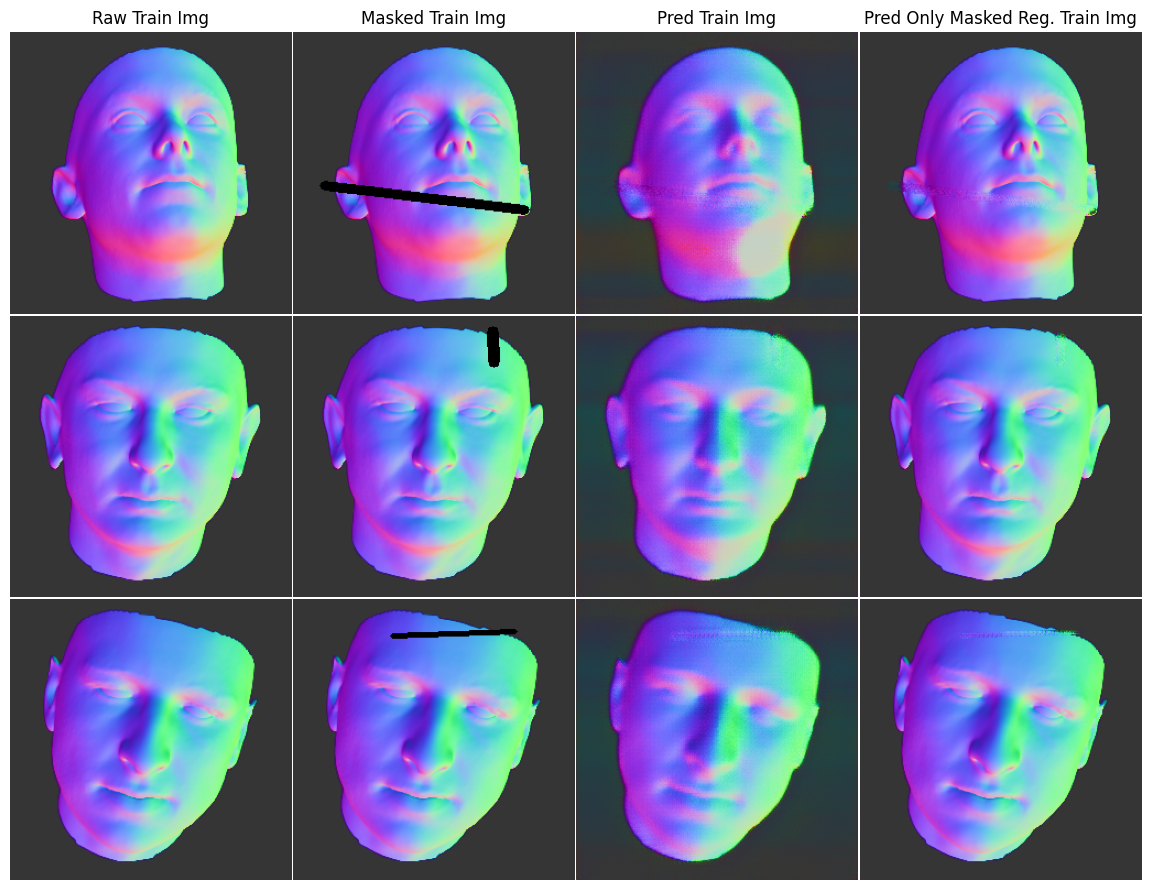

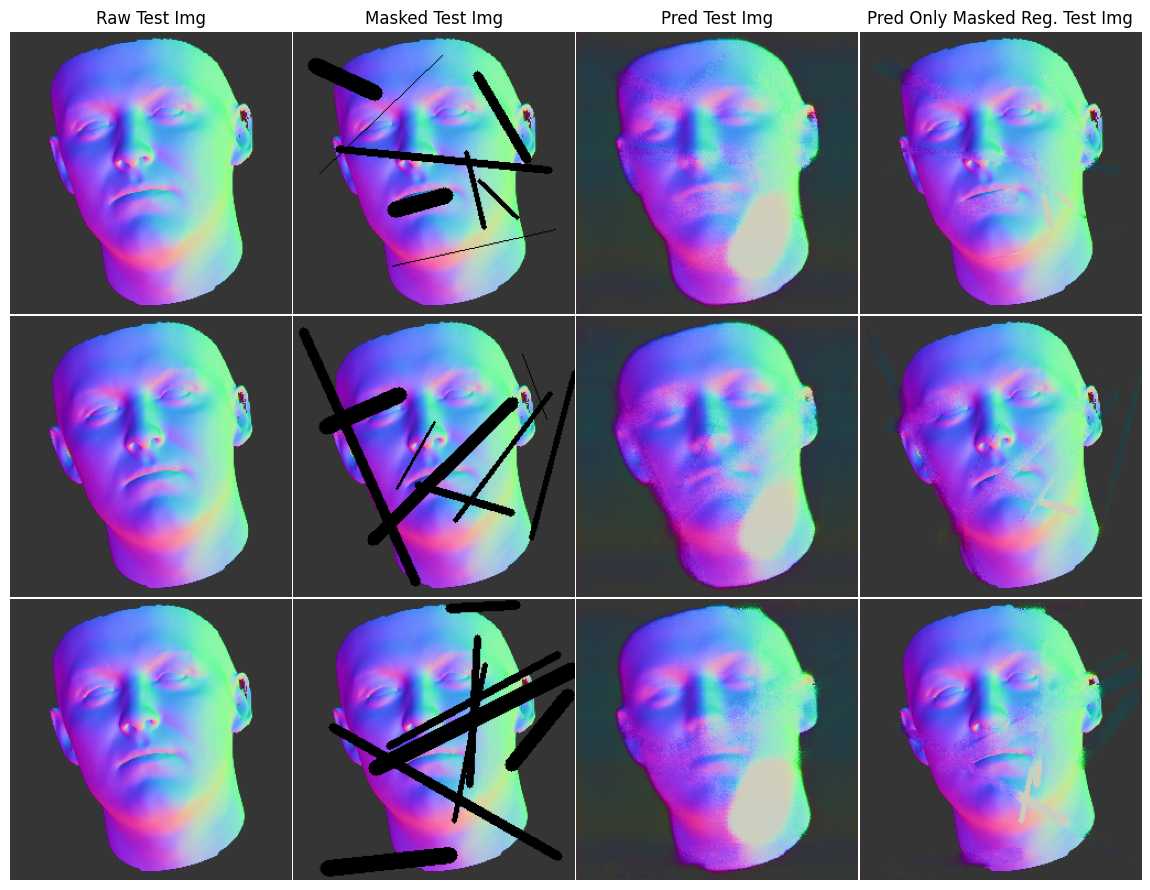

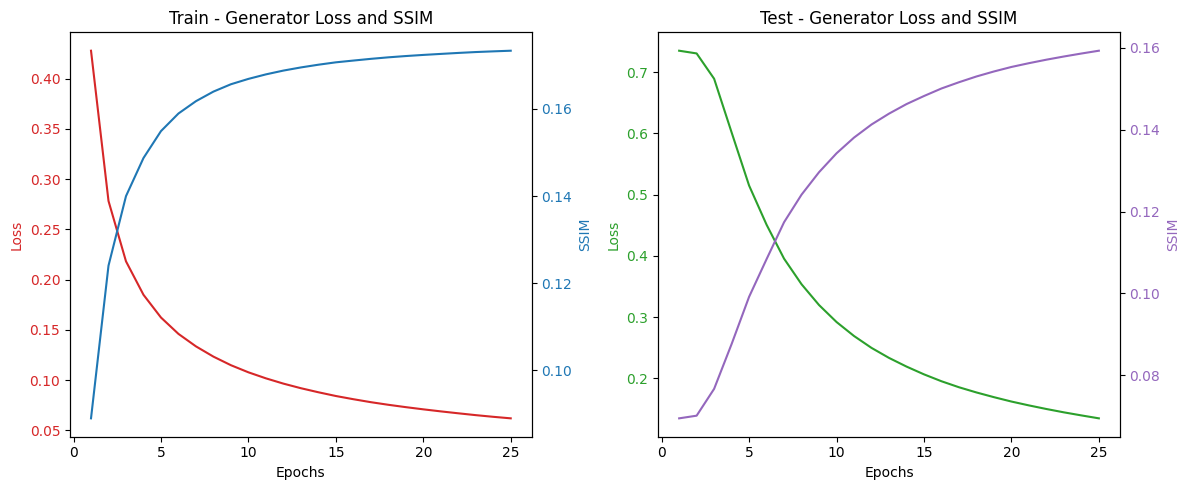

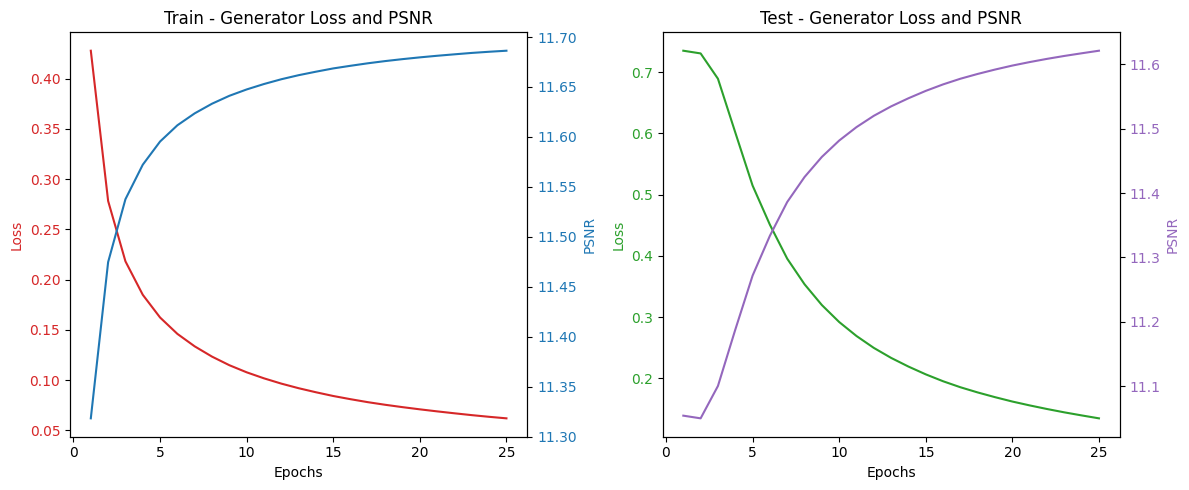

Epoch 26/1000  Train[G_Loss:0.02395 SSIM:17.72% PSNR:11.71]Test[G_Loss:0.02571 SSIM:17.46% PSNR:11.71]- 5s
Epoch 27/1000  Train[G_Loss:0.02457 SSIM:17.67% PSNR:11.71]Test[G_Loss:0.01791 SSIM:17.60% PSNR:11.72]- 5s
Epoch 28/1000  Train[G_Loss:0.02285 SSIM:17.71% PSNR:11.71]Test[G_Loss:0.02169 SSIM:17.53% PSNR:11.71]- 5s
Epoch 29/1000  Train[G_Loss:0.02611 SSIM:17.64% PSNR:11.71]Test[G_Loss:0.02662 SSIM:17.70% PSNR:11.71]- 5s
Epoch 30/1000  Train[G_Loss:0.02614 SSIM:17.69% PSNR:11.71]Test[G_Loss:0.02430 SSIM:17.64% PSNR:11.71]- 5s
Epoch 31/1000  Train[G_Loss:0.02248 SSIM:17.73% PSNR:11.71]Test[G_Loss:0.02365 SSIM:17.43% PSNR:11.70]- 5s
Epoch 32/1000  Train[G_Loss:0.02109 SSIM:17.64% PSNR:11.71]Test[G_Loss:0.02225 SSIM:17.36% PSNR:11.71]- 5s
Epoch 33/1000  Train[G_Loss:0.02113 SSIM:17.62% PSNR:11.71]Test[G_Loss:0.01747 SSIM:17.51% PSNR:11.71]- 5s
Epoch 34/1000  Train[G_Loss:0.02036 SSIM:17.64% PSNR:11.71]Test[G_Loss:0.01722 SSIM:17.49% PSNR:11.71]- 6s
Epoch 35/1000  Train[G_Loss:0.02091 S

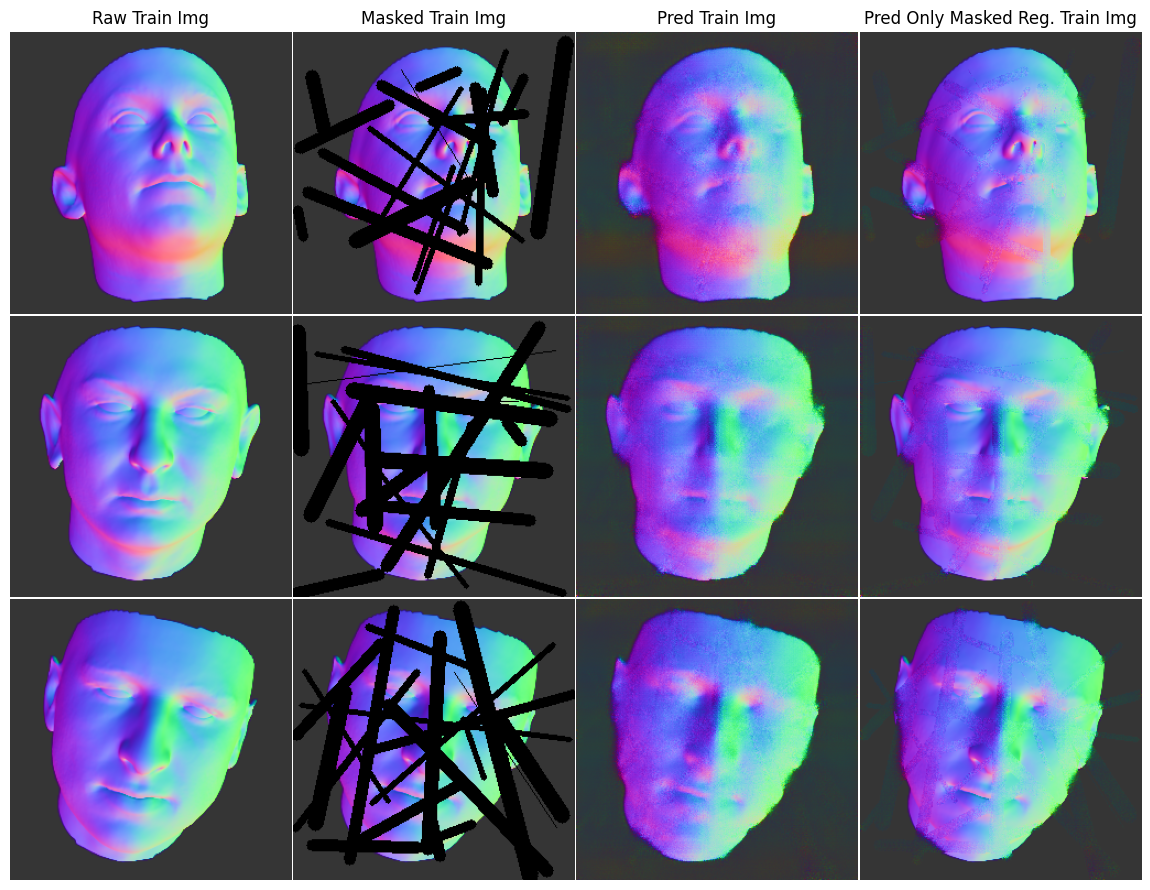

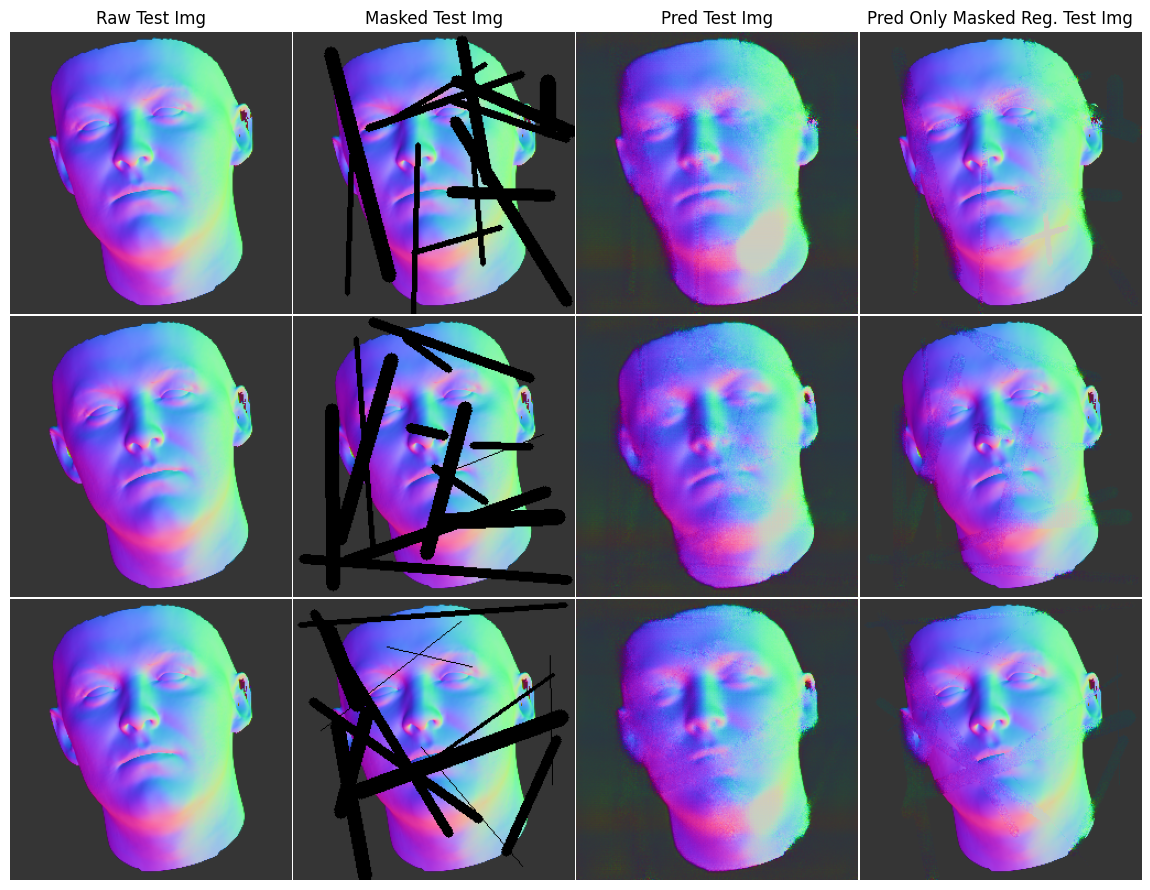

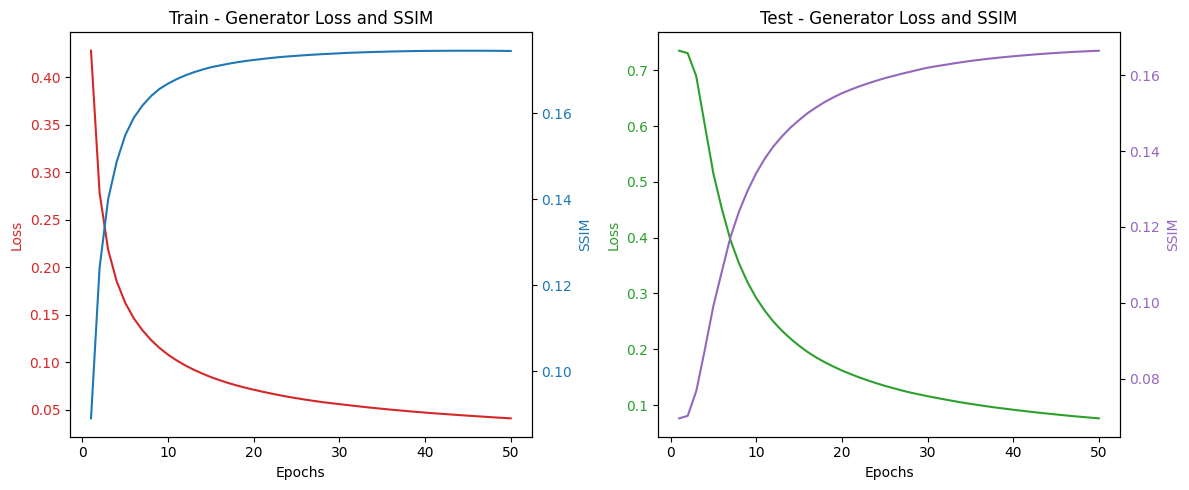

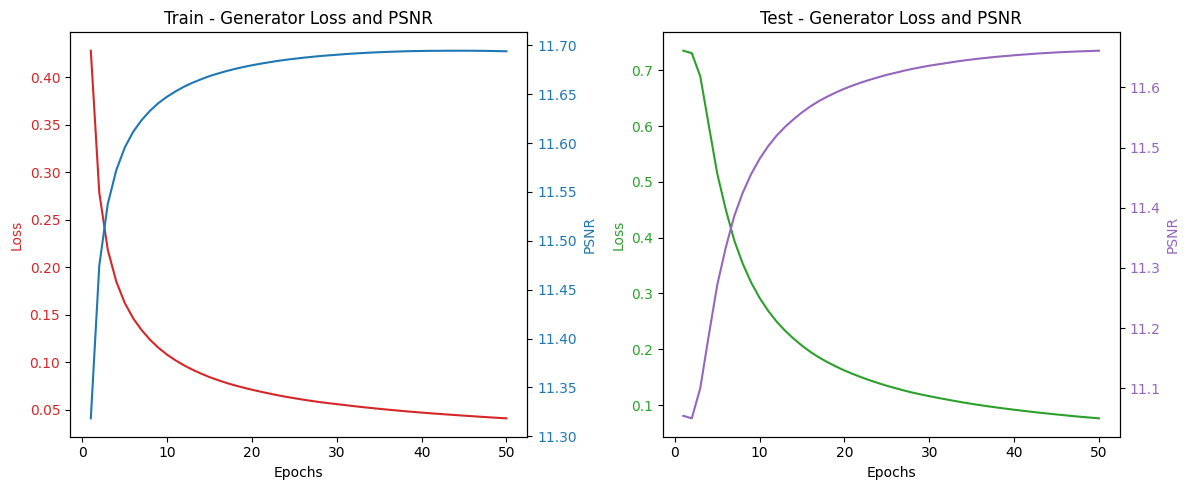

Epoch 51/1000  Train[G_Loss:0.01493 SSIM:17.36% PSNR:11.69]Test[G_Loss:0.01705 SSIM:17.10% PSNR:11.68]- 5s
Epoch 52/1000  Train[G_Loss:0.01438 SSIM:17.34% PSNR:11.68]Test[G_Loss:0.01703 SSIM:17.04% PSNR:11.68]- 5s
Epoch 53/1000  Train[G_Loss:0.01498 SSIM:17.29% PSNR:11.68]Test[G_Loss:0.01573 SSIM:17.07% PSNR:11.68]- 5s
Epoch 54/1000  Train[G_Loss:0.01493 SSIM:17.31% PSNR:11.68]Test[G_Loss:0.01290 SSIM:17.09% PSNR:11.68]- 5s
Epoch 55/1000  Train[G_Loss:0.01472 SSIM:17.32% PSNR:11.68]Test[G_Loss:0.01501 SSIM:17.02% PSNR:11.67]- 5s
Epoch 56/1000  Train[G_Loss:0.01418 SSIM:17.27% PSNR:11.68]Test[G_Loss:0.01455 SSIM:17.00% PSNR:11.67]- 5s
Epoch 57/1000  Train[G_Loss:0.01400 SSIM:17.23% PSNR:11.68]Test[G_Loss:0.01264 SSIM:17.02% PSNR:11.67]- 5s
Epoch 58/1000  Train[G_Loss:0.01311 SSIM:17.25% PSNR:11.68]Test[G_Loss:0.01239 SSIM:17.07% PSNR:11.68]- 5s
Epoch 59/1000  Train[G_Loss:0.01420 SSIM:17.19% PSNR:11.67]Test[G_Loss:0.01415 SSIM:16.97% PSNR:11.67]- 6s
Epoch 60/1000  Train[G_Loss:0.01384 S

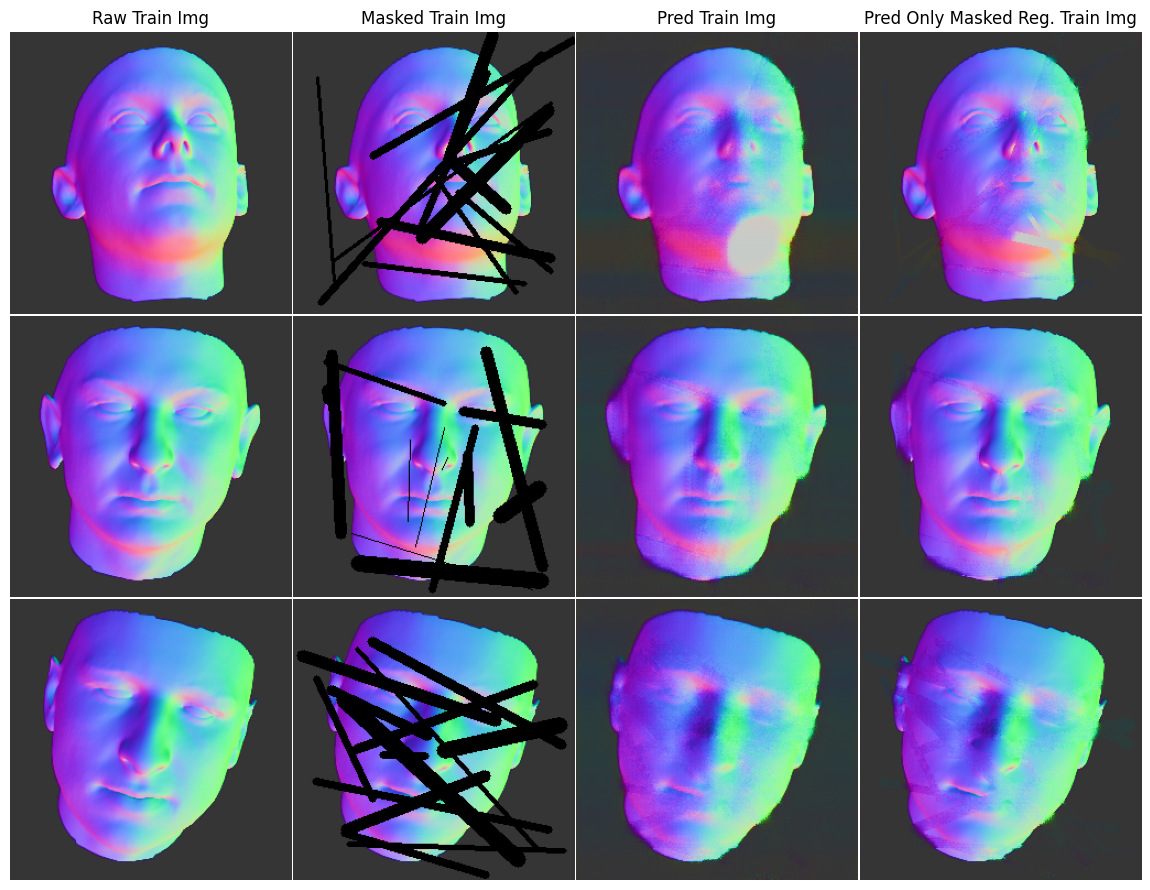

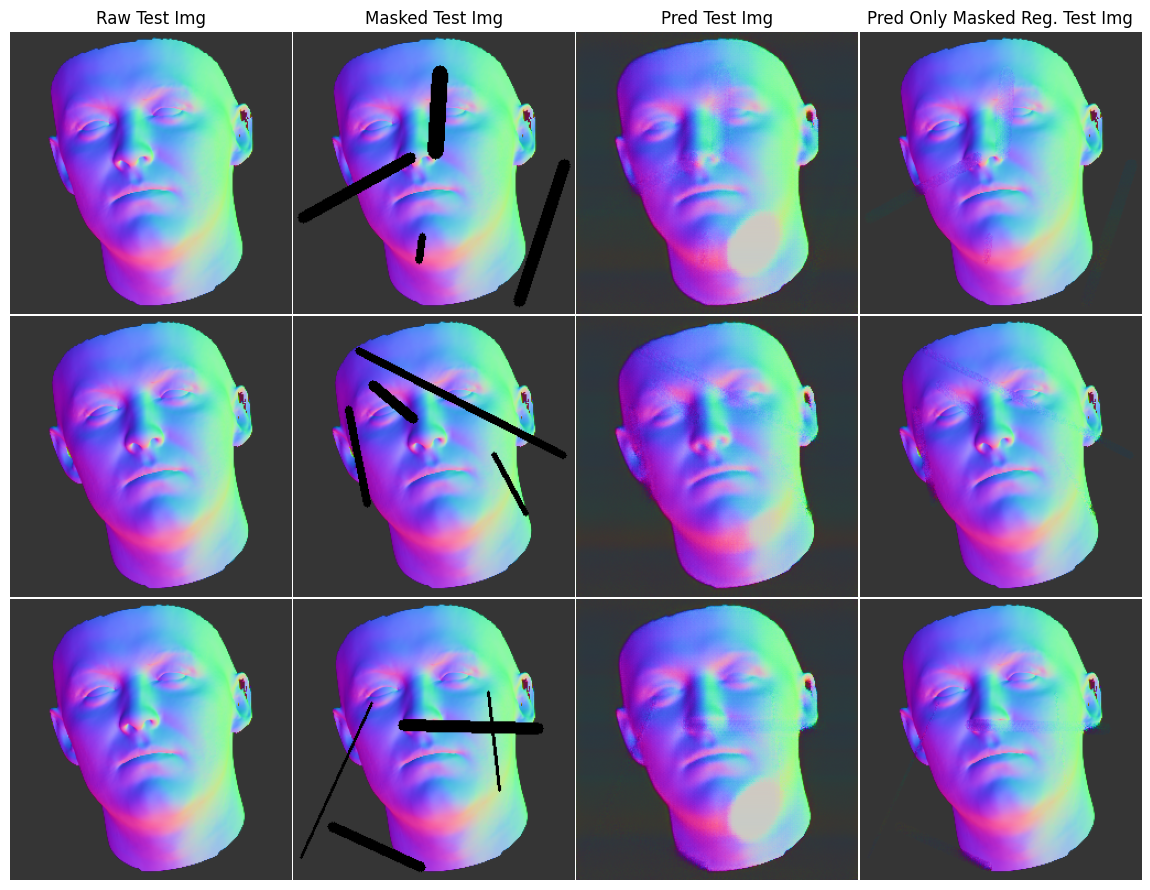

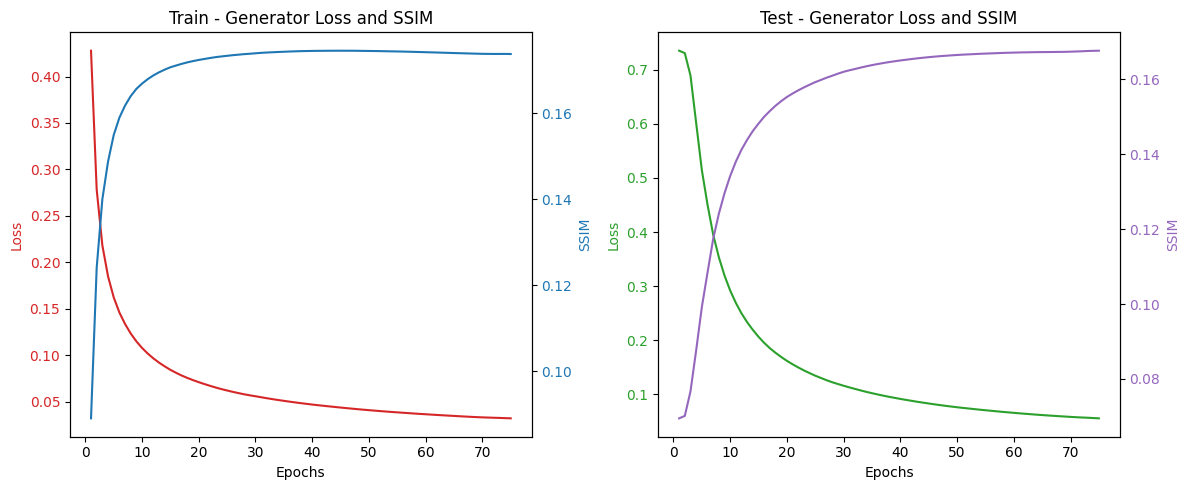

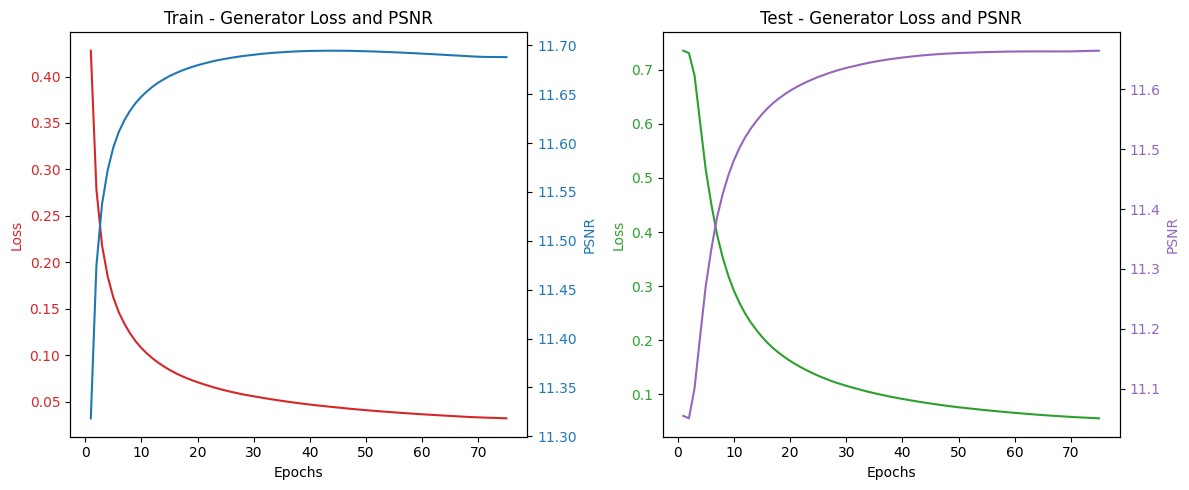

Epoch 76/1000  Train[G_Loss:0.01395 SSIM:17.23% PSNR:11.68]Test[G_Loss:0.01097 SSIM:17.03% PSNR:11.67]- 5s
Epoch 77/1000  Train[G_Loss:0.01230 SSIM:17.22% PSNR:11.68]Test[G_Loss:0.01164 SSIM:17.00% PSNR:11.67]- 5s
Epoch 78/1000  Train[G_Loss:0.01398 SSIM:17.16% PSNR:11.67]Test[G_Loss:0.01357 SSIM:16.93% PSNR:11.67]- 6s
Epoch 79/1000  Train[G_Loss:0.01276 SSIM:17.22% PSNR:11.67]Test[G_Loss:0.01158 SSIM:16.94% PSNR:11.67]- 5s
Epoch 80/1000  Train[G_Loss:0.01170 SSIM:17.15% PSNR:11.67]Test[G_Loss:0.01110 SSIM:16.87% PSNR:11.66]- 5s
Epoch 81/1000  Train[G_Loss:0.01127 SSIM:17.10% PSNR:11.67]Test[G_Loss:0.01076 SSIM:16.84% PSNR:11.66]- 6s
Epoch 82/1000  Train[G_Loss:0.01140 SSIM:17.07% PSNR:11.66]Test[G_Loss:0.00981 SSIM:16.84% PSNR:11.66]- 6s
Epoch 83/1000  Train[G_Loss:0.01121 SSIM:17.07% PSNR:11.66]Test[G_Loss:0.01158 SSIM:16.84% PSNR:11.66]- 6s
Epoch 84/1000  Train[G_Loss:0.01178 SSIM:17.09% PSNR:11.67]Test[G_Loss:0.01167 SSIM:16.93% PSNR:11.67]- 5s
Epoch 85/1000  Train[G_Loss:0.01350 S

In [43]:
model_path = './saved_model/generator.h5'
if not os.path.exists(model_path):
    train(train_dataset, max_epochs = 1000, epoch_break = 25, batches_list_num = 15)
    generator.save('./saved_model/generator.h5')

# Testing and Evaluation on Test Dataset

### Load trained generator

In [44]:
gen_model_pth = './saved_models/generator.h5'
if os.path.exists(gen_model_pth):
    print('Load generator model')
    generator = load_model(gen_model_pth, custom_objects={'UnitNormalize': UnitNormalize})

In [45]:
test_metrics = assessment(test_dataset)

print("Test dataset Avg LOSS: {:.2f}\n"
      "Test dataset Avg SSIM: {:.2f}%\n"
      "Test dataset Avg PSNR: {:.2f}".format(test_metrics['gen_loss'], 
                                                  test_metrics['gen_ssim'] * 100, 
                                                  test_metrics['gen_psnr']))

Test dataset Avg LOSS: 0.01
Test dataset Avg SSIM: 16.79%
Test dataset Avg PSNR: 11.66


In [46]:
print('Pred time for a batch')
for images_batch in test_dataset.take(1):
    test_raw_images = images_batch
    test_mask_channels = mask_irregular(test_raw_images.shape[0], test_raw_images.shape[1], test_raw_images.shape[2])
    test_masked_images = masked_imgs(test_raw_images, test_mask_channels)
    test_pred_images = generator.predict([test_masked_images, test_mask_channels], batch_size=BATCH_SIZE)

Pred time for a batch
1/1 [==============================] - 0s 318ms/step


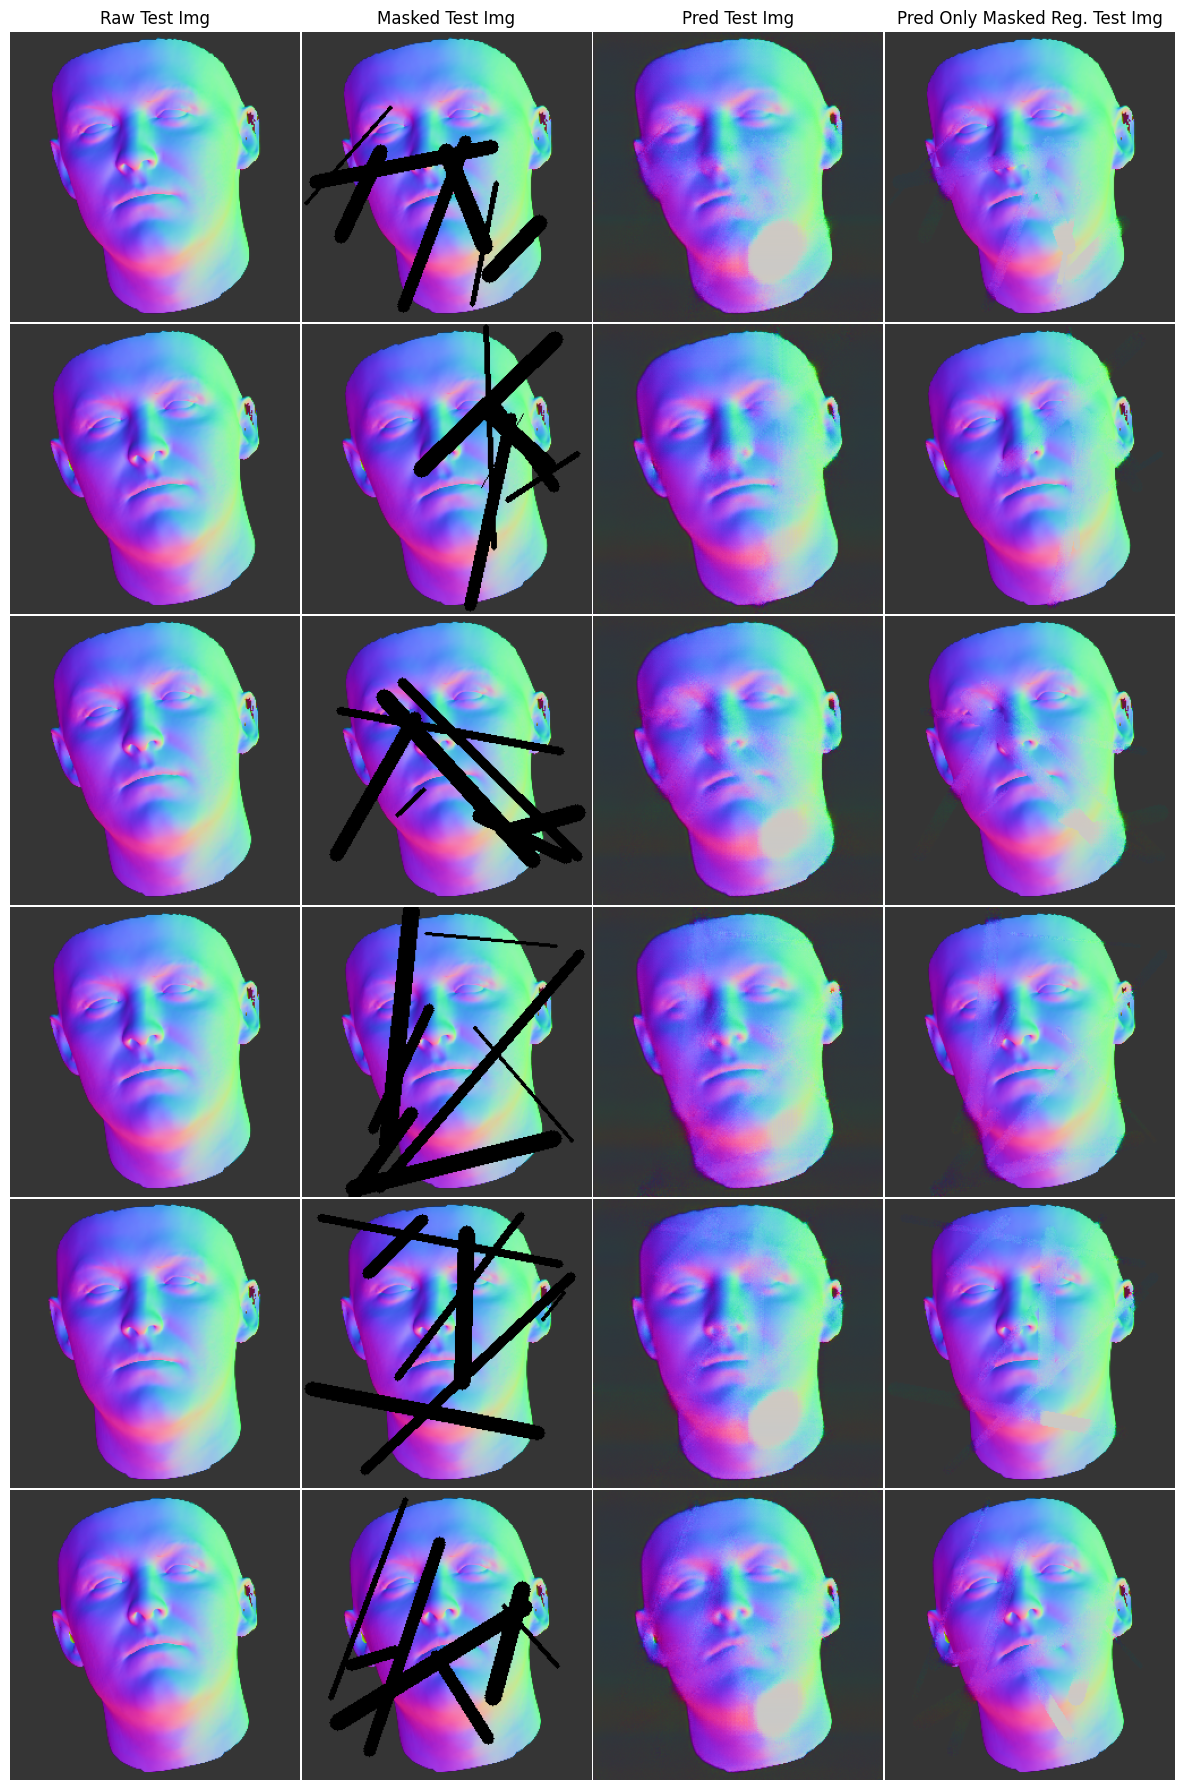

In [47]:
generator_plot_images(generator, 'Test', test_dataset, num = 6)

### Reading and plotting data from log data file

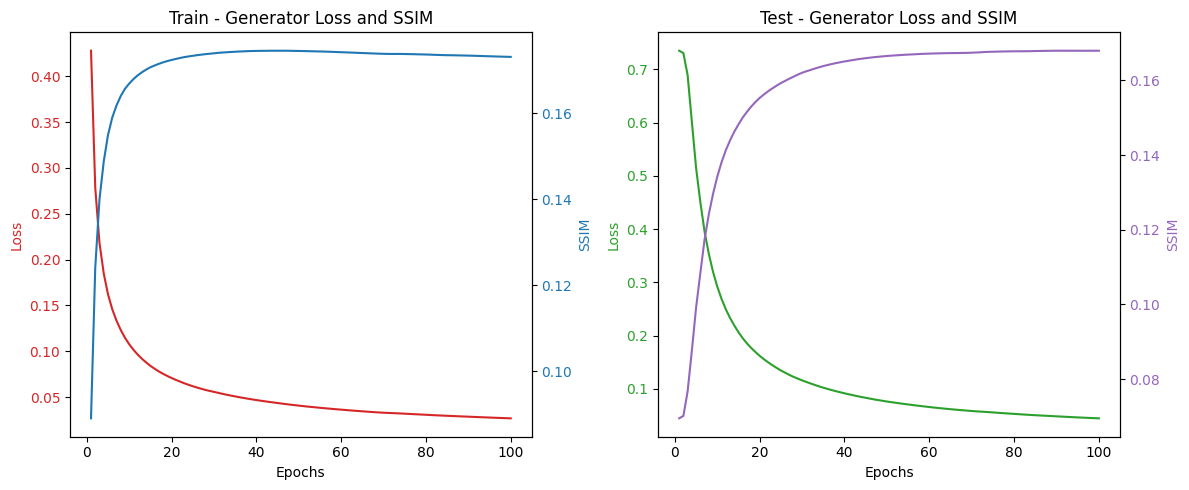

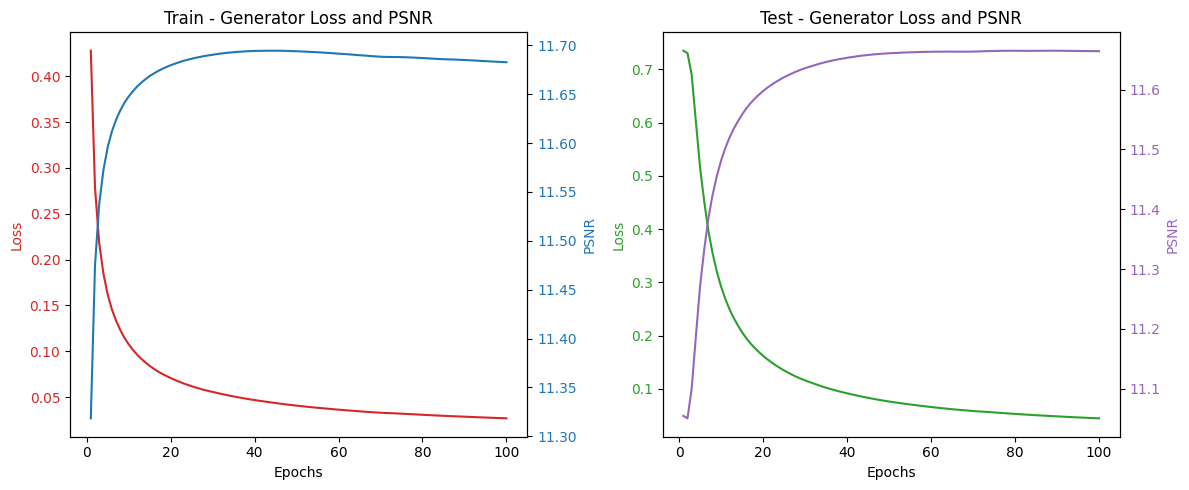

In [48]:
log_dir = './saved_logs'
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, "GAN_training_results.csv")
plot_metrics(load_metrics_from_csv(log_file))